In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from datetime import datetime

# Muat dataset
df = pd.read_csv('line_messenger_reviews.csv')

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

print(f"Data shape: {df.shape}")

# Pastikan kolom konten tidak null dan berupa string
df = df.dropna(subset=['content'])
df['content'] = df['content'].astype(str)

def clean_text(text):
    """Membersihkan teks dari karakter khusus dan mengubah ke lowercase"""
    # Case folding
    text = text.lower()
    # Hapus karakter khusus, angka, dan emoji
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tokenisasi awal - memecah teks menjadi kata-kata setelah cleaning
def tokenize_text(text):
    """Memecah teks menjadi token kata"""
    return text.split()

# Baca dan gabungkan semua kamus normalisasi
def load_normalization_dictionaries():
    """Memuat dan menggabungkan semua kamus normalisasi"""
    try:
        # Read singkatan-lib.csv
        df_singkatan = pd.read_csv("singkatan-lib.csv")
        df_singkatan = df_singkatan.rename(columns={df_singkatan.columns[0]: "slang",
                                                 df_singkatan.columns[1]: "formal"})

        # Baca colloquial-indonesian-lexicon.csv
        df_colloquial = pd.read_csv("colloquial-indonesian-lexicon.csv", sep=",", usecols=["slang", "formal"])

        # Baca Kamus-alay.csv
        df_alay = pd.read_csv("Kamus-Alay.csv", sep=",", usecols=["kataAlay", "kataBaik"])
        df_alay = df_alay.rename(columns={"kataAlay": "slang", "kataBaik": "formal"})

        # Baca slang.csv
        df_slang = pd.read_csv("slang.csv")
        df_slang = df_slang.rename(columns={df_slang.columns[0]: "slang", df_slang.columns[1]: "formal"})

        # Gabungkan semua kamus
        combined_dict = pd.concat([df_singkatan, df_slang, df_colloquial, df_alay], ignore_index=True)

        # Hapus duplikat dengan prioritas pada entri pertama
        combined_dict = combined_dict.drop_duplicates(subset=['slang'], keep='first')

        # Konversi ke dictionary (hapus entri kosong)
        normalization_dict = combined_dict.dropna().set_index("slang")["formal"].to_dict()

        print(f"Loaded {len(normalization_dict)} normalization entries")
        return normalization_dict

    except Exception as e:
        print(f"Error loading dictionaries: {e}")
        return {}

# Muat kamus normalisasi
normalization_dict = load_normalization_dictionaries()

# Normalisasi kata gabungan dengan regex
def normalize_merged_words(tokens):
    """Menormalkan pola kata gabungan yang umum"""
    normalized_tokens = []

    for token in tokens:
        # Tangani pola "ga" + konsonan (contoh: gabisa -> tidak bisa)
        if re.match(r'\bga([bpmdtcjszkgfhv])', token):
            token = re.sub(r'\bga([bpmdtcjszkgfhv]\w*)', r'tidak \1', token)
            # Pisahkan hasil substitusi jika menghasilkan 2 kata
            if ' ' in token:
                normalized_tokens.extend(token.split())
                continue

        # Tangani pola "ga" + vokal (contoh: gausah -> tidak usah)
        elif re.match(r'\bgau([a-z])', token):
            token = re.sub(r'\bgau([a-z]\w*)', r'tidak u\1', token)
            # Pisahkan hasil substitusi jika menghasilkan 2 kata
            if ' ' in token:
                normalized_tokens.extend(token.split())
                continue

        normalized_tokens.append(token)

    return normalized_tokens

# Normalisasi token dengan kamus
def normalize_tokens(tokens):
    """Menormalkan token menggunakan kamus normalisasi"""
    return [normalization_dict.get(token, token) for token in tokens]

# Muat stopwords
def load_stopwords():
    """Memuat dan menggabungkan daftar stopwords dari berbagai sumber"""
    def load_stopwords_file(file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                return f.read().split()
        except Exception as e:
            print(f"Warning: Could not load {file_path}: {e}")
            return []

    # Path file stopword
    stoplist_path = "stoplist.txt"
    indonesian_path = "indonesian.txt"
    stopwordsid_path = "stopwords-id.txt"
    id_stopwords_path = "id.stopwords.02.01.2016.txt"
    kamus_path = "kamus.txt"

    # Muat stopwords dari files
    stopwords_combined = []
    for path in [stoplist_path, indonesian_path, stopwordsid_path, id_stopwords_path, kamus_path]:
        stopwords_combined.extend(load_stopwords_file(path))

    # Dapatkan stopwords dari Sastrawi
    stopword_factory = StopWordRemoverFactory()
    sastrawi_stopwords = stopword_factory.get_stop_words()

    # Gabungkan dan hapus duplikat
    stopwords_combined.extend(sastrawi_stopwords)

    # Tambahkan kata kustom
    custom_stopwords = ['line', 'nya', 'sih', 'yg', 'dah', 'ga', 'gak', 'aja', 'saja', 'juga', 'untuk']
    stopwords_combined.extend(custom_stopwords)

    final_stopwords = list(set(stopwords_combined))

    print(f"Loaded {len(final_stopwords)} stopwords")
    return final_stopwords

# Muat stopwords
final_stopwords = load_stopwords()

# Hapus stopwords
def remove_stopwords(tokens):
    """Menghapus stopwords dari daftar token"""
    return [token for token in tokens if token not in final_stopwords and len(token) > 1]

# Inisialisasi stemmer
stemmer = StemmerFactory().create_stemmer()

# Stem token
def stem_tokens(tokens):
    """Melakukan stemming pada daftar token"""
    return [stemmer.stem(token) for token in tokens]

# Pipeline preprocessing lengkap
def preprocess_text(text):
    """Pipeline preprocessing lengkap"""
    if pd.isna(text) or text == "":
        return []

    # 1. Cleaning
    cleaned = clean_text(text)

    # 2. Tokenisasi awal
    tokens = tokenize_text(cleaned)

    # 3. Normalisasi kata gabungan
    tokens = normalize_merged_words(tokens)

    # 4. Normalisasi dengan kamus
    tokens = normalize_tokens(tokens)

    # 5. Hapus stopwords
    tokens = remove_stopwords(tokens)

    # 6. Stemming
    tokens = stem_tokens(tokens)

    # 7. Filter token terlalu pendek
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

# Terapkan preprocessing
print("Melakukan preprocessing...")
df['tokens'] = df['content'].apply(preprocess_text)

# Hapus dokumen kosong setelah preprocessing
df = df[df['tokens'].apply(len) > 0]
print(f"Jumlah dokumen setelah preprocessing: {df.shape[0]}")

# Simpan teks yang sudah di-preprocess sebagai string untuk TF-IDF
df['preprocessed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Simpan data untuk LDA
lda_df = df[['preprocessed_text', 'tokens']]
lda_df.to_csv('preprocessed_lda.csv', index=False)

print("Preprocessing selesai dan data disimpan ke 'preprocessed_lda.csv'")

Data shape: (7000, 6)
Loaded 6436 normalization entries
Loaded 1164 stopwords
Melakukan preprocessing...
Jumlah dokumen setelah preprocessing: 6807
Preprocessing selesai dan data disimpan ke 'preprocessed_lda.csv'


<ipython-input-4-34d55204b943>:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preprocessed_text'] = df['tokens'].apply(lambda x: ' '.join(x))


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# 1. Load Data Preprocessing
print("Loading preprocessed data...")
df = pd.read_csv('preprocessed_lda.csv')

# Drop rows with NaN values
df = df.dropna(subset=['tokens'])
corpus = df['tokens'].tolist()

# 2. Feature Extraction - TF-IDF dengan Feature Selection
print("Extracting features...")
vectorizer = TfidfVectorizer(
    max_df=0.90,  # Ignore terms that appear in more than 90% of documents
    min_df=5,     # Ignore terms that appear in fewer than 5 documents
    max_features=1000,  # Slightly increased from 800 for more coverage
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # At least 3 characters to avoid noise
)

tfidf_matrix = vectorizer.fit_transform(corpus)
print(f"Dimensi Matriks TF-IDF: {tfidf_matrix.shape}")

# === VISUALISASI TF-IDF ===

def show_tfidf_transformation(vectorizer, tfidf_matrix, corpus, sample_indices=None, num_samples=3):
    """
    Menampilkan transformasi teks menjadi TF-IDF dengan detail
    """
    print(f"\n{'='*80}")
    print("VISUALISASI TRANSFORMASI TEKS KE TF-IDF")
    print(f"{'='*80}")

    # Get feature names (vocabulary)
    feature_names = vectorizer.get_feature_names_out()

    # Pilih sampel
    if sample_indices is None:
        sample_indices = np.random.choice(len(corpus), min(num_samples, len(corpus)), replace=False)

    for i, idx in enumerate(sample_indices):
        print(f"\n{'='*60}")
        print(f"SAMPEL {i+1} (Index: {idx})")
        print(f"{'='*60}")

        # Teks asli
        original_text = corpus[idx]
        print(f"TEKS ASLI:\n{original_text}")

        # Kata-kata dalam teks
        words_in_text = original_text.split()
        print(f"\nKATA-KATA DALAM TEKS ({len(words_in_text)} kata):")
        print(f"{' | '.join(words_in_text)}")

        # TF-IDF vector untuk dokumen ini
        tfidf_vector = tfidf_matrix[idx].toarray().flatten()

        # Temukan kata-kata yang ada dalam vocabulary
        words_in_vocab = []
        tfidf_scores = []

        for word in words_in_text:
            if word in feature_names:
                word_idx = list(feature_names).index(word)
                score = tfidf_vector[word_idx]
                words_in_vocab.append(word)

Loading preprocessed data...
Extracting features...
Dimensi Matriks TF-IDF: (14425, 1000)


Loading preprocessed data...
Extracting features...
Dimensi Matriks TF-IDF: (14425, 1000)

MEMULAI VISUALISASI TF-IDF

VISUALISASI TRANSFORMASI TEKS KE TF-IDF

SAMPEL 1 (Index: 2023)
TEKS ASLI:
['mantap']

KATA-KATA DALAM TEKS (1 kata):
['mantap']

KATA-KATA YANG ADA DALAM VOCABULARY (0 dari 1 kata):

KATA-KATA YANG TIDAK ADA DALAM VOCABULARY (1 kata):
  ['mantap']
  (Kemungkinan karena min_df, max_df, atau max_features)

TOP TF-IDF SCORES UNTUK DOKUMEN INI:
  mantap: 1.0000

STATISTIK VEKTOR TF-IDF:
  Dimensi total: 1000
  Nilai non-zero: 1
  Sparsity: 99.90%
  Rata-rata TF-IDF: 0.001000
  Std TF-IDF: 0.031607
  Max TF-IDF: 1.0000

SAMPEL 2 (Index: 3657)
TEKS ASLI:
['makin', 'susah', 'login', 'handphone', 'lama', 'hilang', 'jadi', 'susah', 'verifikasi', 'baik', 'fitur', 'susah', 'guna']

KATA-KATA DALAM TEKS (13 kata):
['makin', | 'susah', | 'login', | 'handphone', | 'lama', | 'hilang', | 'jadi', | 'susah', | 'verifikasi', | 'baik', | 'fitur', | 'susah', | 'guna']

KATA-KATA YANG ADA 

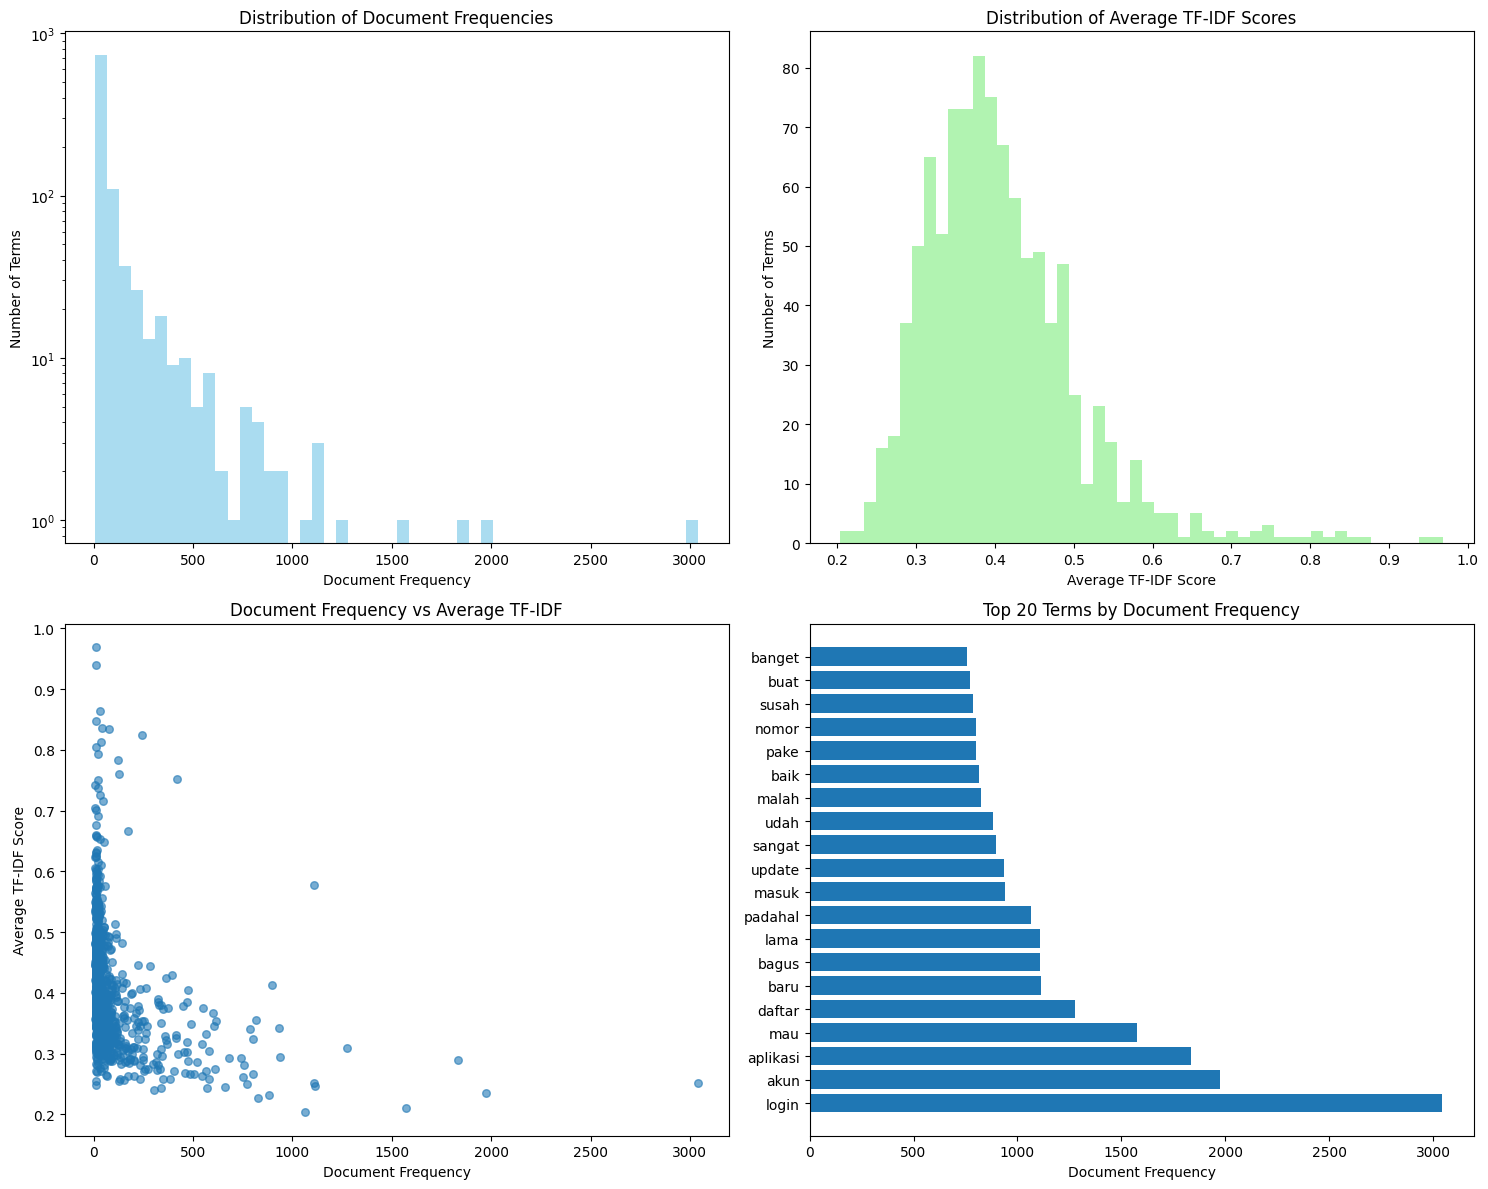


HEATMAP TF-IDF SCORES


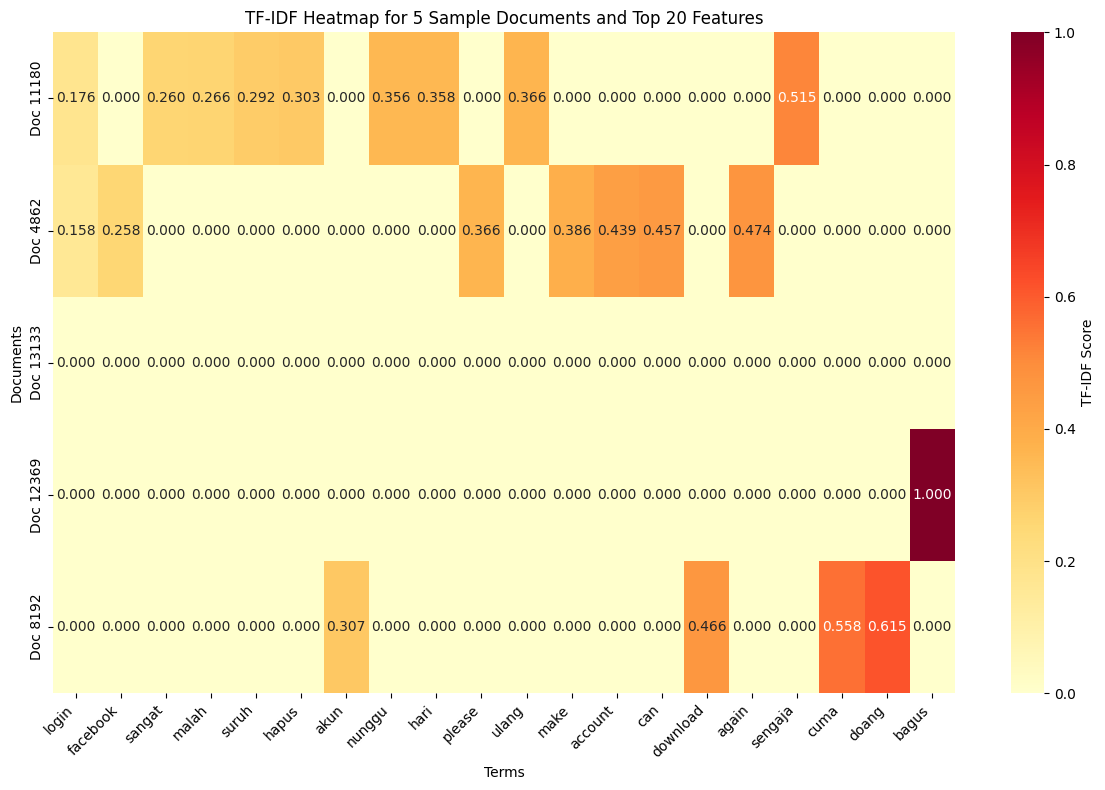


ANALISIS SPARSITY MATRIKS TF-IDF
Dimensi matriks: (14425, 1000)
Total elemen: 14,425,000
Elemen non-zero: 90,454
Sparsity: 99.37%

STATISTIK PER DOKUMEN:
Rata-rata kata per dokumen: 6.27
Median kata per dokumen: 4.00
Min kata per dokumen: 0
Max kata per dokumen: 46

STATISTIK PER TERM:
Rata-rata dokumen per term: 90.45
Median dokumen per term: 27.00
Min dokumen per term: 5
Max dokumen per term: 3043


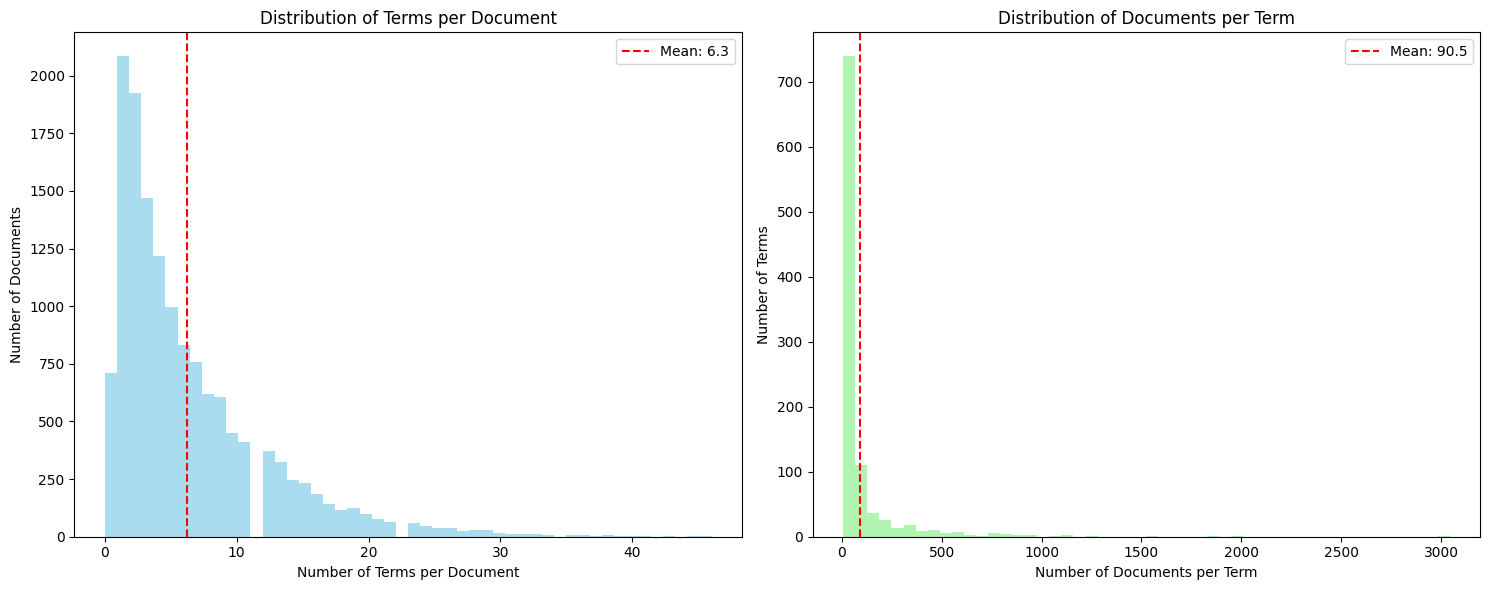


VISUALISASI TF-IDF SELESAI
File yang dihasilkan:
- tfidf_vocabulary_stats.png
- tfidf_heatmap.png
- tfidf_sparsity_analysis.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# 1. Load Data Preprocessing
print("Loading preprocessed data...")
df = pd.read_csv('preprocessed_lda.csv')

# Drop rows with NaN values
df = df.dropna(subset=['tokens'])
corpus = df['tokens'].tolist()

# 2. Feature Extraction - TF-IDF dengan Feature Selection
print("Extracting features...")
vectorizer = TfidfVectorizer(
    max_df=0.90,  # Ignore terms that appear in more than 90% of documents
    min_df=5,     # Ignore terms that appear in fewer than 5 documents
    max_features=1000,  # Slightly increased from 800 for more coverage
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # At least 3 characters to avoid noise
)

tfidf_matrix = vectorizer.fit_transform(corpus)
print(f"Dimensi Matriks TF-IDF: {tfidf_matrix.shape}")

# === VISUALISASI TF-IDF ===

def show_tfidf_transformation(vectorizer, tfidf_matrix, corpus, sample_indices=None, num_samples=3):
    """
    Menampilkan transformasi teks menjadi TF-IDF dengan detail
    """
    print(f"\n{'='*80}")
    print("VISUALISASI TRANSFORMASI TEKS KE TF-IDF")
    print(f"{'='*80}")

    # Get feature names (vocabulary)
    feature_names = vectorizer.get_feature_names_out()

    # Pilih sampel
    if sample_indices is None:
        sample_indices = np.random.choice(len(corpus), min(num_samples, len(corpus)), replace=False)

    for i, idx in enumerate(sample_indices):
        print(f"\n{'='*60}")
        print(f"SAMPEL {i+1} (Index: {idx})")
        print(f"{'='*60}")

        # Teks asli
        original_text = corpus[idx]
        print(f"TEKS ASLI:\n{original_text}")

        # Kata-kata dalam teks
        words_in_text = original_text.split()
        print(f"\nKATA-KATA DALAM TEKS ({len(words_in_text)} kata):")
        print(f"{' | '.join(words_in_text)}")

        # TF-IDF vector untuk dokumen ini
        tfidf_vector = tfidf_matrix[idx].toarray().flatten()

        # Temukan kata-kata yang ada dalam vocabulary
        words_in_vocab = []
        tfidf_scores = []

        for word in words_in_text:
            if word in feature_names:
                word_idx = list(feature_names).index(word)
                score = tfidf_vector[word_idx]
                words_in_vocab.append(word)
                tfidf_scores.append(score)

        print(f"\nKATA-KATA YANG ADA DALAM VOCABULARY ({len(words_in_vocab)} dari {len(words_in_text)} kata):")
        for word, score in zip(words_in_vocab, tfidf_scores):
            print(f"  {word}: {score:.4f}")

        # Kata-kata yang tidak ada dalam vocabulary
        words_not_in_vocab = [word for word in words_in_text if word not in feature_names]
        if words_not_in_vocab:
            print(f"\nKATA-KATA YANG TIDAK ADA DALAM VOCABULARY ({len(words_not_in_vocab)} kata):")
            print(f"  {' | '.join(words_not_in_vocab)}")
            print("  (Kemungkinan karena min_df, max_df, atau max_features)")

        # Top TF-IDF scores untuk dokumen ini
        top_indices = tfidf_vector.argsort()[-10:][::-1]  # Top 10
        top_words = [feature_names[i] for i in top_indices if tfidf_vector[i] > 0]
        top_scores = [tfidf_vector[i] for i in top_indices if tfidf_vector[i] > 0]

        print(f"\nTOP TF-IDF SCORES UNTUK DOKUMEN INI:")
        for word, score in zip(top_words, top_scores):
            print(f"  {word}: {score:.4f}")

        # Statistik vektor TF-IDF
        non_zero_count = np.count_nonzero(tfidf_vector)
        print(f"\nSTATISTIK VEKTOR TF-IDF:")
        print(f"  Dimensi total: {len(tfidf_vector)}")
        print(f"  Nilai non-zero: {non_zero_count}")
        print(f"  Sparsity: {(1 - non_zero_count/len(tfidf_vector))*100:.2f}%")
        print(f"  Rata-rata TF-IDF: {np.mean(tfidf_vector):.6f}")
        print(f"  Std TF-IDF: {np.std(tfidf_vector):.6f}")
        print(f"  Max TF-IDF: {np.max(tfidf_vector):.4f}")

def visualize_vocabulary_statistics(vectorizer, tfidf_matrix):
    """
    Visualisasi statistik vocabulary dan TF-IDF
    """
    print(f"\n{'='*80}")
    print("STATISTIK VOCABULARY DAN TF-IDF")
    print(f"{'='*80}")

    feature_names = vectorizer.get_feature_names_out()

    # Hitung statistik untuk setiap term
    term_stats = []
    for i, term in enumerate(feature_names):
        # TF-IDF scores untuk term ini di semua dokumen
        term_tfidf = tfidf_matrix[:, i].toarray().flatten()

        # Hitung statistik
        doc_freq = np.count_nonzero(term_tfidf)  # Document frequency
        avg_tfidf = np.mean(term_tfidf[term_tfidf > 0])  # Average TF-IDF (non-zero)
        max_tfidf = np.max(term_tfidf)

        term_stats.append({
            'term': term,
            'doc_freq': doc_freq,
            'avg_tfidf': avg_tfidf,
            'max_tfidf': max_tfidf
        })

    # Convert to DataFrame
    vocab_df = pd.DataFrame(term_stats)

    # Print top terms by different criteria
    print("\nTOP 10 TERMS BY DOCUMENT FREQUENCY:")
    top_by_freq = vocab_df.nlargest(10, 'doc_freq')
    for _, row in top_by_freq.iterrows():
        print(f"  {row['term']}: {row['doc_freq']} dokumen ({row['doc_freq']/len(tfidf_matrix.toarray())*100:.1f}%)")

    print("\nTOP 10 TERMS BY AVERAGE TF-IDF:")
    top_by_avg = vocab_df.nlargest(10, 'avg_tfidf')
    for _, row in top_by_avg.iterrows():
        print(f"  {row['term']}: {row['avg_tfidf']:.4f}")

    print("\nTOP 10 TERMS BY MAX TF-IDF:")
    top_by_max = vocab_df.nlargest(10, 'max_tfidf')
    for _, row in top_by_max.iterrows():
        print(f"  {row['term']}: {row['max_tfidf']:.4f}")

    # Visualisasi
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Histogram Document Frequency
    axes[0, 0].hist(vocab_df['doc_freq'], bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('Document Frequency')
    axes[0, 0].set_ylabel('Number of Terms')
    axes[0, 0].set_title('Distribution of Document Frequencies')
    axes[0, 0].set_yscale('log')

    # 2. Histogram Average TF-IDF
    axes[0, 1].hist(vocab_df['avg_tfidf'], bins=50, alpha=0.7, color='lightgreen')
    axes[0, 1].set_xlabel('Average TF-IDF Score')
    axes[0, 1].set_ylabel('Number of Terms')
    axes[0, 1].set_title('Distribution of Average TF-IDF Scores')

    # 3. Scatter plot Doc Freq vs Avg TF-IDF
    axes[1, 0].scatter(vocab_df['doc_freq'], vocab_df['avg_tfidf'], alpha=0.6, s=30)
    axes[1, 0].set_xlabel('Document Frequency')
    axes[1, 0].set_ylabel('Average TF-IDF Score')
    axes[1, 0].set_title('Document Frequency vs Average TF-IDF')

    # 4. Top 20 terms by document frequency
    top_20_freq = vocab_df.nlargest(20, 'doc_freq')
    axes[1, 1].barh(range(len(top_20_freq)), top_20_freq['doc_freq'])
    axes[1, 1].set_yticks(range(len(top_20_freq)))
    axes[1, 1].set_yticklabels(top_20_freq['term'])
    axes[1, 1].set_xlabel('Document Frequency')
    axes[1, 1].set_title('Top 20 Terms by Document Frequency')

    plt.tight_layout()
    plt.savefig('tfidf_vocabulary_stats.png', dpi=300, bbox_inches='tight')
    plt.show()

    return vocab_df

def create_tfidf_heatmap(tfidf_matrix, feature_names, sample_indices=None, num_samples=5, num_features=20):
    """
    Membuat heatmap TF-IDF untuk sampel dokumen
    """
    print(f"\n{'='*80}")
    print("HEATMAP TF-IDF SCORES")
    print(f"{'='*80}")

    if sample_indices is None:
        sample_indices = np.random.choice(tfidf_matrix.shape[0], min(num_samples, tfidf_matrix.shape[0]), replace=False)

    # Ambil sampel dokumen
    sample_matrix = tfidf_matrix[sample_indices].toarray()

    # Pilih top features berdasarkan variance
    feature_variance = np.var(sample_matrix, axis=0)
    top_feature_indices = np.argsort(feature_variance)[-num_features:]

    # Buat heatmap data
    heatmap_data = sample_matrix[:, top_feature_indices]
    feature_labels = [feature_names[i] for i in top_feature_indices]
    doc_labels = [f"Doc {i}" for i in sample_indices]

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data,
                xticklabels=feature_labels,
                yticklabels=doc_labels,
                cmap='YlOrRd',
                annot=True,
                fmt='.3f',
                cbar_kws={'label': 'TF-IDF Score'})

    plt.title(f'TF-IDF Heatmap for {num_samples} Sample Documents and Top {num_features} Features')
    plt.xlabel('Terms')
    plt.ylabel('Documents')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('tfidf_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_tfidf_sparsity(tfidf_matrix):
    """
    Analisis sparsity dari matriks TF-IDF
    """
    print(f"\n{'='*80}")
    print("ANALISIS SPARSITY MATRIKS TF-IDF")
    print(f"{'='*80}")

    # Konversi ke dense array untuk analisis
    dense_matrix = tfidf_matrix.toarray()

    # Hitung sparsity
    total_elements = dense_matrix.shape[0] * dense_matrix.shape[1]
    non_zero_elements = np.count_nonzero(dense_matrix)
    sparsity = (1 - non_zero_elements / total_elements) * 100

    print(f"Dimensi matriks: {dense_matrix.shape}")
    print(f"Total elemen: {total_elements:,}")
    print(f"Elemen non-zero: {non_zero_elements:,}")
    print(f"Sparsity: {sparsity:.2f}%")

    # Analisis per dokumen
    doc_non_zero = np.count_nonzero(dense_matrix, axis=1)
    print(f"\nSTATISTIK PER DOKUMEN:")
    print(f"Rata-rata kata per dokumen: {np.mean(doc_non_zero):.2f}")
    print(f"Median kata per dokumen: {np.median(doc_non_zero):.2f}")
    print(f"Min kata per dokumen: {np.min(doc_non_zero)}")
    print(f"Max kata per dokumen: {np.max(doc_non_zero)}")

    # Analisis per term
    term_non_zero = np.count_nonzero(dense_matrix, axis=0)
    print(f"\nSTATISTIK PER TERM:")
    print(f"Rata-rata dokumen per term: {np.mean(term_non_zero):.2f}")
    print(f"Median dokumen per term: {np.median(term_non_zero):.2f}")
    print(f"Min dokumen per term: {np.min(term_non_zero)}")
    print(f"Max dokumen per term: {np.max(term_non_zero)}")

    # Visualisasi
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Histogram kata per dokumen
    axes[0].hist(doc_non_zero, bins=50, alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Number of Terms per Document')
    axes[0].set_ylabel('Number of Documents')
    axes[0].set_title('Distribution of Terms per Document')
    axes[0].axvline(np.mean(doc_non_zero), color='red', linestyle='--', label=f'Mean: {np.mean(doc_non_zero):.1f}')
    axes[0].legend()

    # Histogram dokumen per term
    axes[1].hist(term_non_zero, bins=50, alpha=0.7, color='lightgreen')
    axes[1].set_xlabel('Number of Documents per Term')
    axes[1].set_ylabel('Number of Terms')
    axes[1].set_title('Distribution of Documents per Term')
    axes[1].axvline(np.mean(term_non_zero), color='red', linestyle='--', label=f'Mean: {np.mean(term_non_zero):.1f}')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('tfidf_sparsity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# === JALANKAN SEMUA VISUALISASI ===

print("\n" + "="*80)
print("MEMULAI VISUALISASI TF-IDF")
print("="*80)

# 1. Tampilkan transformasi teks ke TF-IDF
show_tfidf_transformation(vectorizer, tfidf_matrix, corpus, num_samples=3)

# 2. Visualisasi statistik vocabulary
vocab_df = visualize_vocabulary_statistics(vectorizer, tfidf_matrix)

# 3. Buat heatmap TF-IDF
create_tfidf_heatmap(tfidf_matrix, vectorizer.get_feature_names_out(), num_samples=5, num_features=20)

# 4. Analisis sparsity
analyze_tfidf_sparsity(tfidf_matrix)

print("\n" + "="*80)
print("VISUALISASI TF-IDF SELESAI")
print("="*80)
print("File yang dihasilkan:")
print("- tfidf_vocabulary_stats.png")
print("- tfidf_heatmap.png")
print("- tfidf_sparsity_analysis.png")

In [ ]:
# 4. Train the final LDA model with the optimal number of topics
n_topics_optimal = 3

print(f"Training final LDA model with {n_topics_optimal} topics...")
lda_model = LatentDirichletAllocation(
    n_components=n_topics_optimal,
    learning_method='online',
    random_state=42,
    n_jobs=-1,
    max_iter=30,  # Increased iterations for better convergence
    doc_topic_prior=0.05,  # Reduced alpha for more specific topics
    topic_word_prior=0.01   # Low beta for focused word distributions
)

# Assuming _matrix is your TF-IDF matrix
lda_model.fit(tfidf_matrix)
print("Final LDA model trained successfully!")

Training final LDA model with 3 topics...
Final LDA model trained successfully!


In [ ]:
# 5. Analyze and visualize topics
def print_topics(model, vectorizer, n_words=15):
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics.append(top_words)
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")
    return topics

print("\nTop Keywords per Topic:")
topics = print_topics(lda_model, vectorizer)



Top Keywords per Topic:
Topic #1: bagus, oke, galat, aplikasi, blokir, mantap, teman, terus, pesan, masuk, suka, kirim, terima, google, akun
Topic #2: voom, fitur, hilang, telepon, cerita, good, hapus, nomor, kecewa, jelek, kembali, indonesia, buka, simpan, update
Topic #3: masuk, akun, pakai, aplikasi, handphone, kak, daftar, facebook, susah, ribet, nomor, email, buruk, telpon, baik


In [ ]:
# 6. Advanced Topic Assignment with Multi-Topic Support
def assign_topics(doc_topic_dist, threshold=0.5):
    multi_topics = []
    for doc_dist in doc_topic_dist:
        # Find indices of topics above the threshold
        topic_indices = np.where(doc_dist >= threshold)[0]

        # Sort topics by their scores in descending order
        sorted_topics = sorted(
            [(idx + 1, doc_dist[idx]) for idx in topic_indices],
            key=lambda x: x[1],
            reverse=True
        )

        # Store the topics and their scores
        multi_topics.append(sorted_topics)

    return multi_topics

# Get topic distribution for each document
doc_topic_dist = lda_model.transform(tfidf_matrix)

# Assign topics with a 0.5 threshold
multi_topic_assignments = assign_topics(doc_topic_dist, threshold=0.45)

In [ ]:
# 7. Assign meaningful names to topics
topic_names = {
    1: "Pengalaman Umum Penggunaan dan Perpesanan di LINE",
    2: "Keluhan terhadap Fitur Tambahan dan Pembaruan Aplikasi",
    3: "Kendala Login dan Registrasi Akun",
}

# Add multi-topic information to the DataFrame
df['multi_topics'] = [
    ' & '.join([f"Topic {t} ({topic_names[t]}) [{score:.2f}]" for t, score in topics])
    if topics else "No significant topics"
    for topics in multi_topic_assignments
]

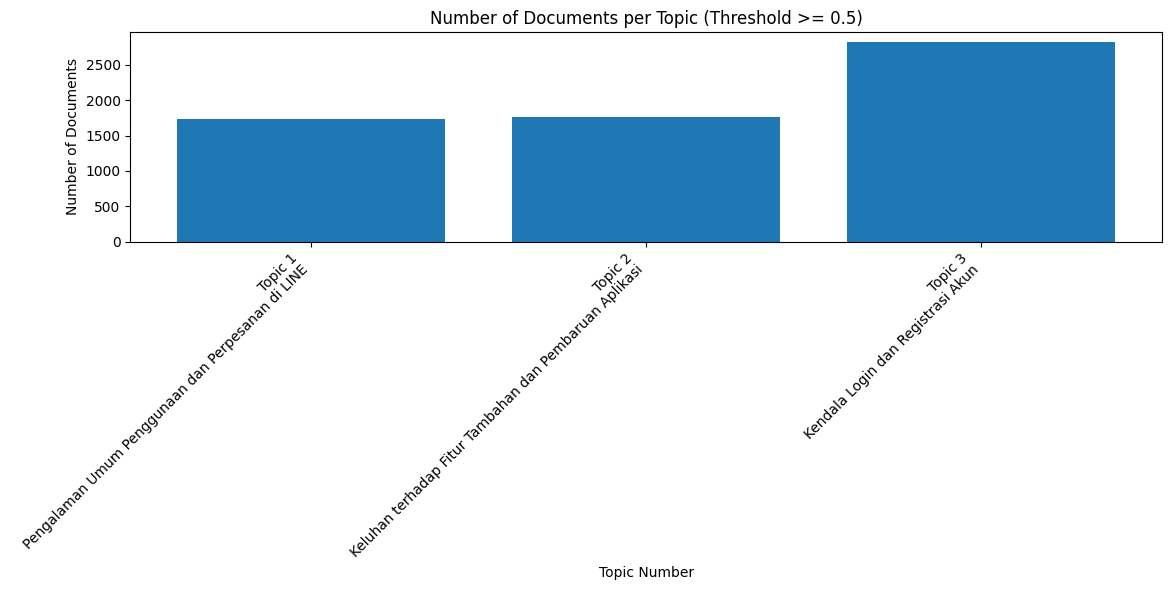

In [ ]:
# Optional: Visualization of topic distribution
plt.figure(figsize=(12, 6))
topic_distribution = np.sum(doc_topic_dist >= 0.5, axis=0)
plt.bar(range(1, n_topics_optimal + 1), topic_distribution)
plt.title('Number of Documents per Topic (Threshold >= 0.5)')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.xticks(range(1, n_topics_optimal + 1),
           [f"Topic {i}\n{topic_names[i]}" for i in range(1, n_topics_optimal + 1)],
           rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Print some statistics
print("\nMulti-Topic Document Analysis:")
total_docs = len(multi_topic_assignments)
multi_topic_docs = sum(1 for topics in multi_topic_assignments if len(topics) > 1)
print(f"Total Documents: {total_docs}")
print(f"Documents with Multiple Topics: {multi_topic_docs}")
print(f"Percentage of Multi-Topic Documents: {multi_topic_docs/total_docs*100:.2f}%")



Multi-Topic Document Analysis:
Total Documents: 6807
Documents with Multiple Topics: 232
Percentage of Multi-Topic Documents: 3.41%


In [ ]:
pip install wordcloud matplotlib pandas numpy

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Generating wordclouds...
Word clouds saved as 'topic_wordclouds.png'


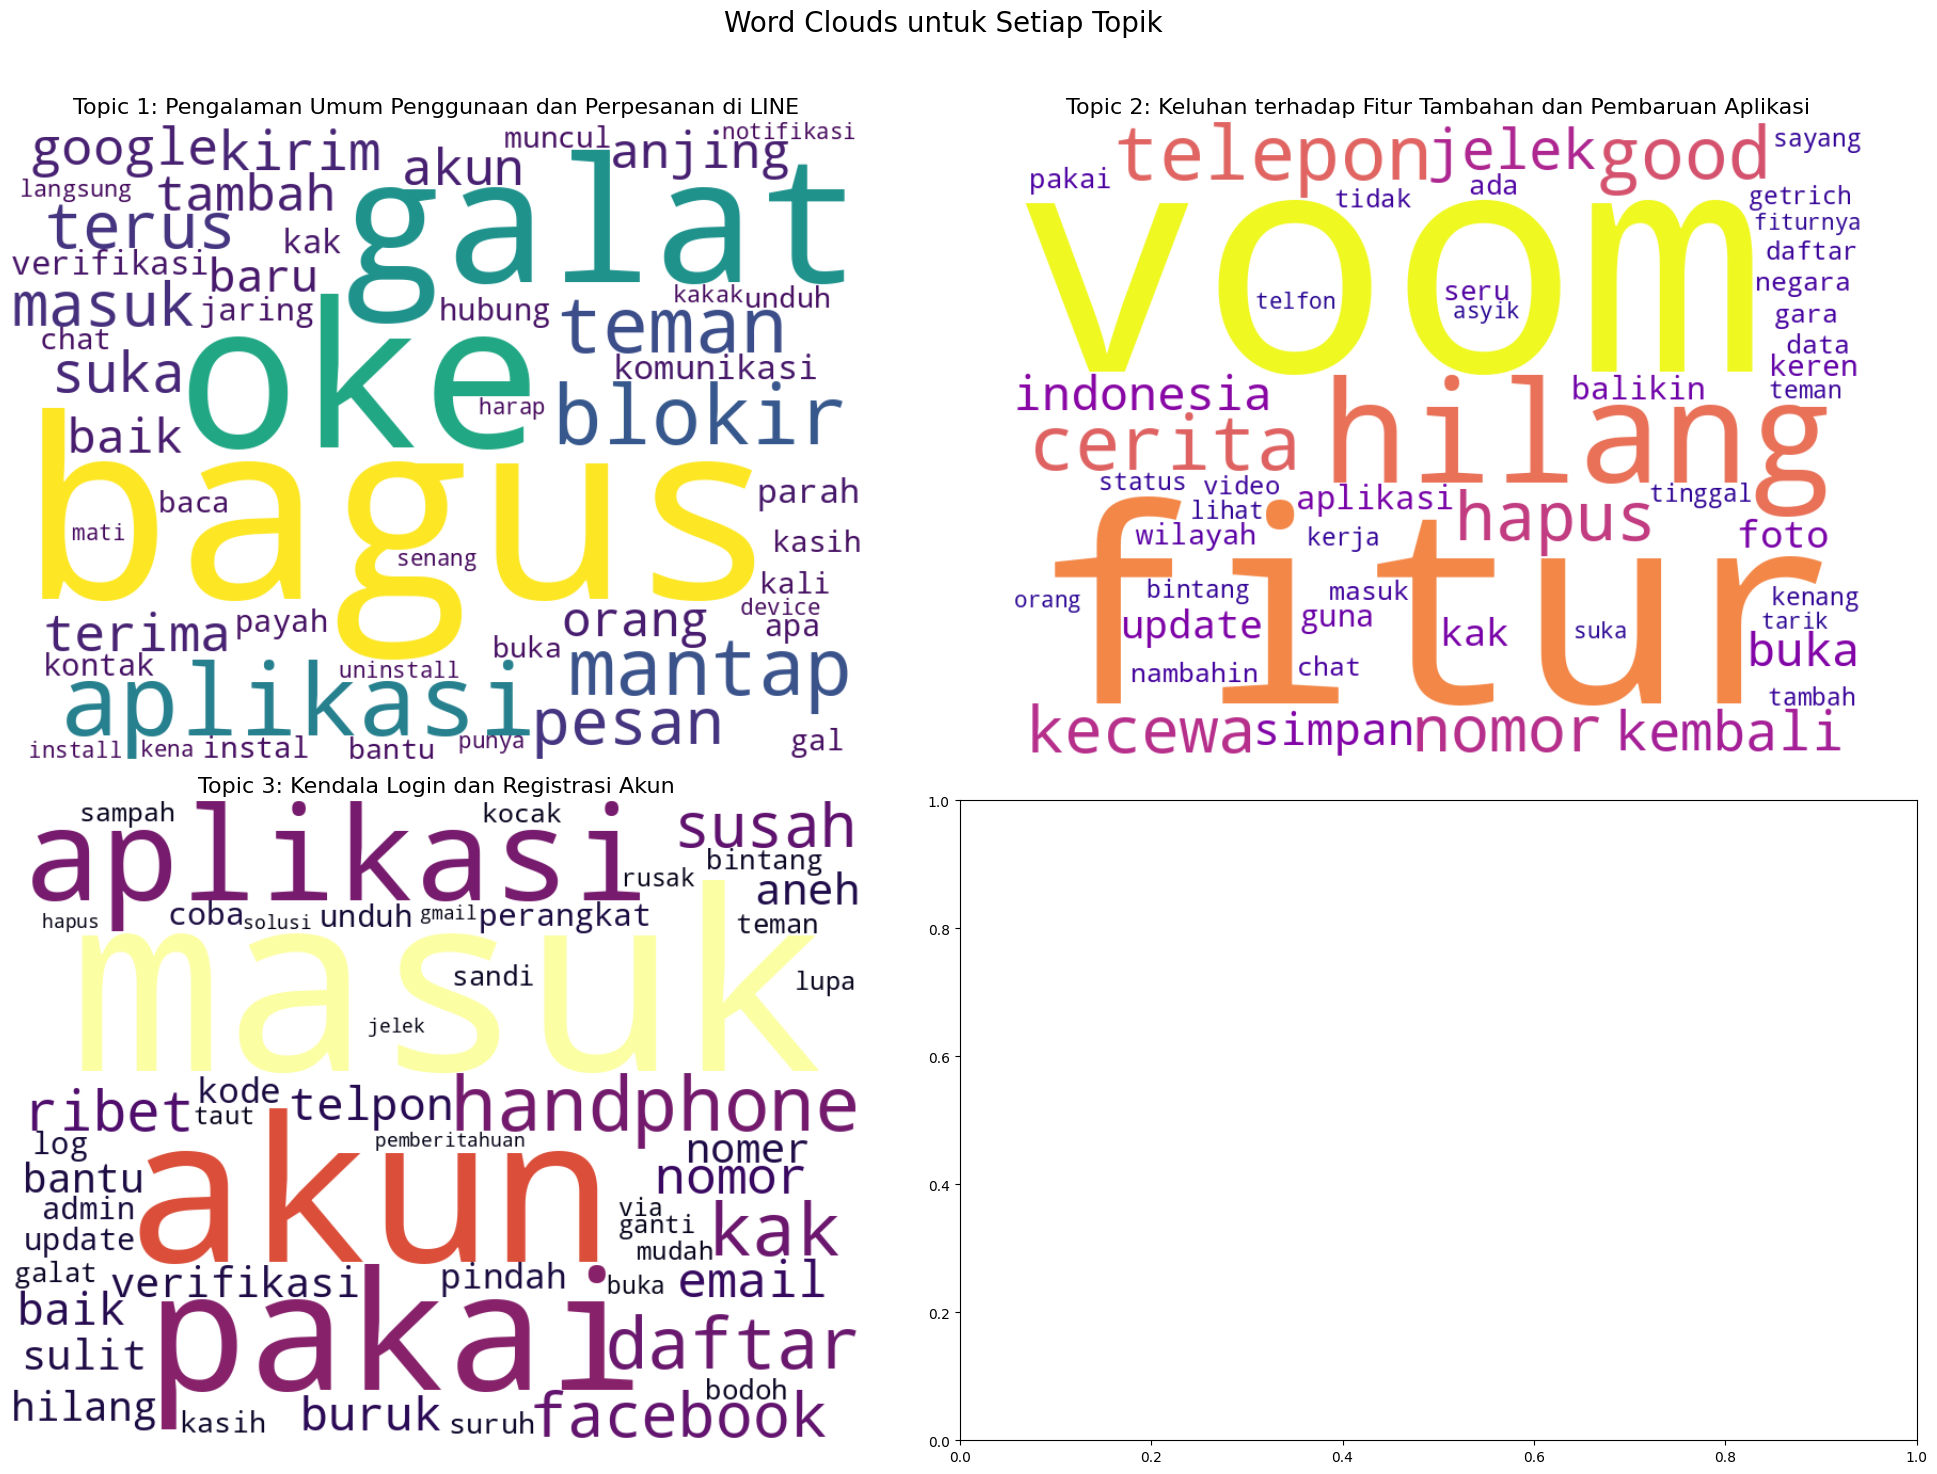

In [ ]:
# Function to generate word cloud for each topic
def generate_wordclouds(lda_model, vectorizer, topic_names, n_top_words=100): # Added vectorizer as an argument
    print("Generating wordclouds...")
    # Define some nice color gradients for the word clouds
    colors = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma]

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Word Clouds untuk Setiap Topik', fontsize=20)

    # Get feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out() # Get feature names here

    # Create word cloud for each topic
    for i, (topic_idx, topic) in enumerate(topic_names.items()):
        ax = axes[i//2, i%2]

        # Get topic weights
        topic_weights = lda_model.components_[topic_idx-1]

        # Get top words and their weights
        top_word_indices = topic_weights.argsort()[-n_top_words:][::-1]
        top_words = {feature_names[i]: topic_weights[i] for i in top_word_indices}

        # Create a color function with a chosen colormap
        def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
            # Normalize the word weight to get a value between 0 and 1
            weight = top_words.get(word, 0.1)
            normalized_weight = (weight - min(top_words.values())) / (max(top_words.values()) - min(top_words.values()))

            # Convert the normalized weight to an RGB color tuple with integer values
            color = tuple(int(c * 255) for c in colors[i](normalized_weight)[:3])  # Get RGB values and convert to integers

            return color  # Return the RGB color tuple

        # Generate word cloud
        wc = WordCloud(
            background_color='white',
            max_words=50,
            width=800,
            height=600,
            prefer_horizontal=1.0,
            color_func=color_func,
            random_state=42
        ).generate_from_frequencies(top_words)

        # Display the word cloud
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f"Topic {topic_idx}: {topic}", fontsize=16)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# Generate and save word clouds
wordcloud_fig = generate_wordclouds(lda_model, vectorizer, topic_names) # Pass the vectorizer to the function
wordcloud_fig.savefig('topic_wordclouds.png', dpi=300, bbox_inches='tight')
print("Word clouds saved as 'topic_wordclouds.png'")

In [ ]:
# Optional: Save results to CSV
df.to_csv('lda_multi_topic_results.csv', index=False)
print("\nResults saved to 'lda_multi_topic_results.csv'")


Results saved to 'lda_multi_topic_results.csv'


In [ ]:
# Simpan DataFrame dengan topik ke CSV
df.to_csv('preprocessed_lda_with_topics.csv', index=False)

# Simpan model LDA menggunakan pickle
import pickle

with open('lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)

# Simpan vectorizer juga jika diperlukan
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("File CSV dan model LDA berhasil disimpan!")

File CSV dan model LDA berhasil disimpan!


In [ ]:
from google.colab import files

files.download('preprocessed_lda_with_topics.csv')
files.download('lda_model.pkl')
files.download('vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data shape: (15000, 6)
Error loading dictionaries: [Errno 2] No such file or directory: 'singkatan-lib.csv'
Loaded 131 stopwords
Memulai preprocessing dengan visualisasi...
Melakukan preprocessing dengan visualisasi...

1. CLEANING TEXT...

CONTOH CLEANING

Contoh 1:
BEFORE: KENAPA STORY SAMA TIMELINE DIILANGIN, MANA TL AKUN SENDIRI JUGA:(
AFTER:  kenapa story sama timeline diilangin mana tl akun sendiri juga
------------------------------------------------------------

Contoh 2:
BEFORE: saya kecewakan karena fitur untuk login menggunakan Facebook sudah tidak bisa saya gunakan lagi sungguh mengecewakan sakali, dan sungguh bodoh nya aplikasi ini ketika kita mengalami kendala tidak dapat akses operator untuk mengajukan laporan malah di jauhkan ke sistem auto yang tidak dapat di pahami
AFTER:  saya kecewakan karena fitur untuk login menggunakan facebook sudah tidak bisa saya gunakan lagi sungguh mengecewakan sakali dan sungguh bodoh nya aplikasi ini ketika kita mengalami kendala tidak dap

/tmp/ipython-input-4-894785725.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preprocessed_text'] = df['tokens'].apply(lambda x: ' '.join(x))
/tmp/ipython-input-4-894785725.py:371: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_to_plot, labels=['Original', 'After Preprocessing'])


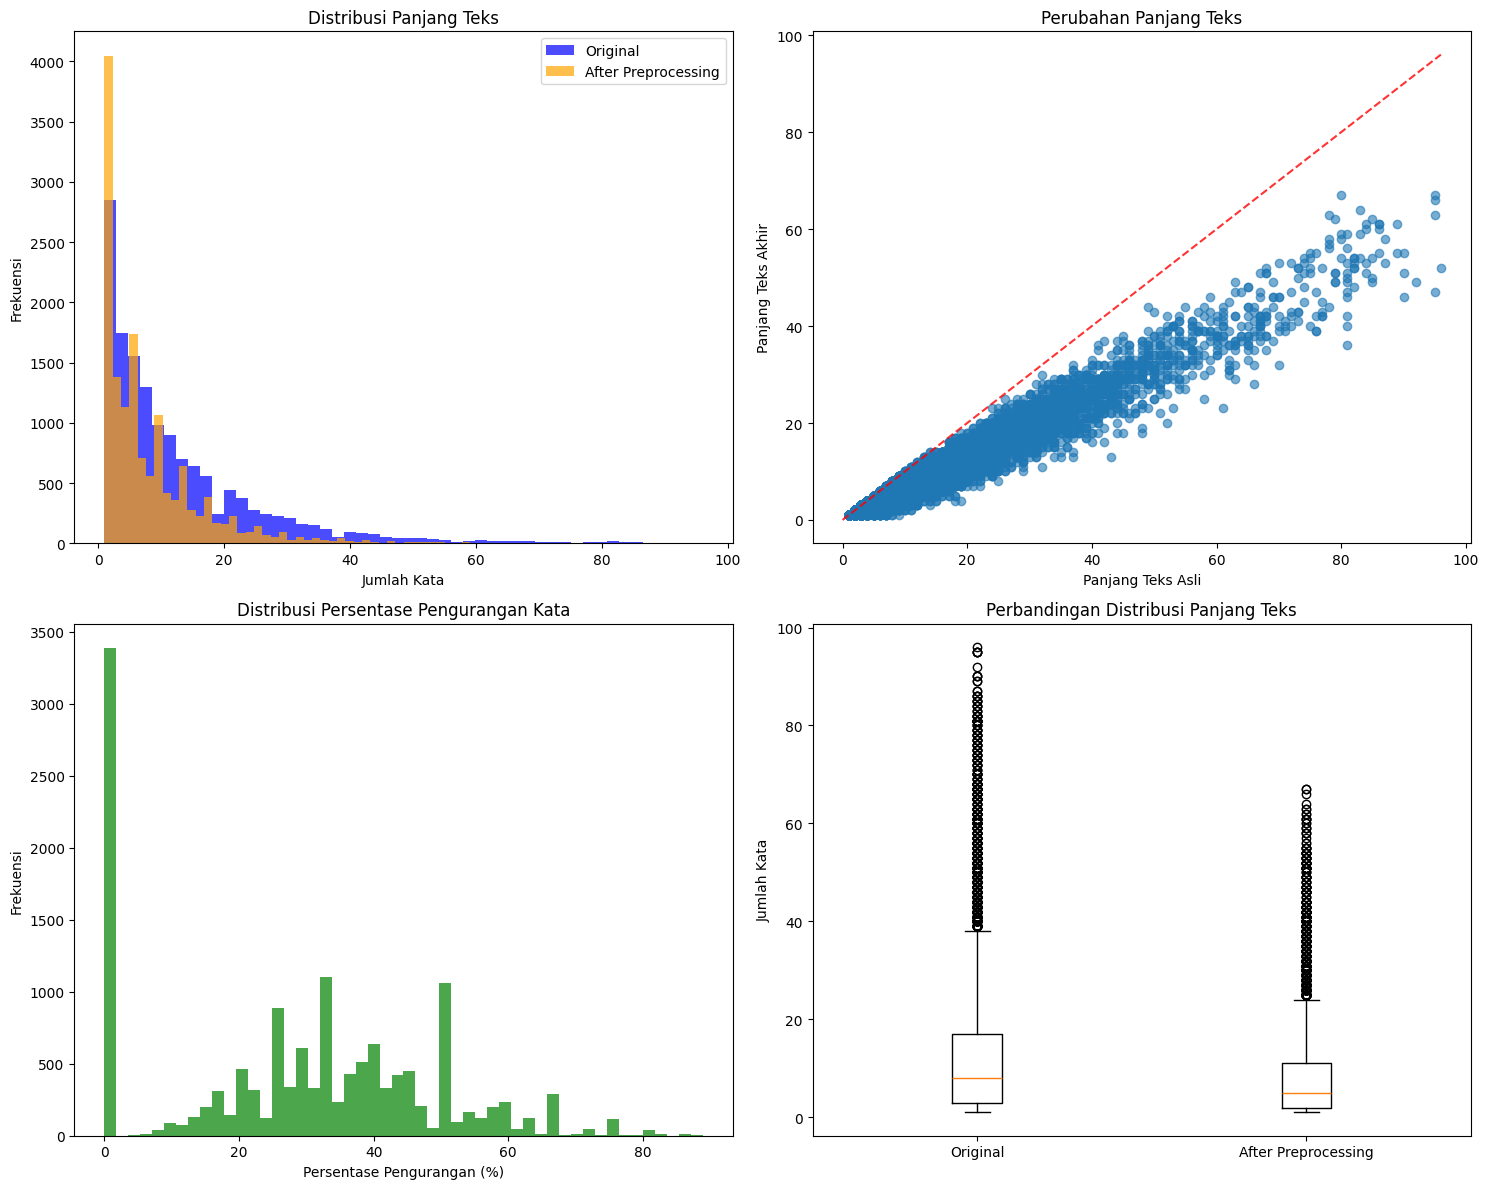


STATISTIK RINGKASAN:
Rata-rata panjang teks asli: 12.47 kata
Rata-rata panjang teks akhir: 8.09 kata
Rata-rata pengurangan: 28.60%
Median pengurangan: 30.77%

Preprocessing selesai dan data disimpan ke 'preprocessed_lda.csv'
Visualisasi statistik disimpan ke 'preprocessing_stats.png'


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

print(f"Data shape: {df.shape}")

# Pastikan kolom konten tidak null dan berupa string
df = df.dropna(subset=['content'])
df['content'] = df['content'].astype(str)

def clean_text(text):
    """Membersihkan teks dari karakter khusus dan mengubah ke lowercase"""
    # Case folding
    text = text.lower()
    # Hapus karakter khusus, angka, dan emoji
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tokenisasi awal - memecah teks menjadi kata-kata setelah cleaning
def tokenize_text(text):
    """Memecah teks menjadi token kata"""
    return text.split()

# Baca dan gabungkan semua kamus normalisasi
def load_normalization_dictionaries():
    """Memuat dan menggabungkan semua kamus normalisasi"""
    try:
        # Read singkatan-lib.csv
        df_singkatan = pd.read_csv("singkatan-lib.csv")
        df_singkatan = df_singkatan.rename(columns={df_singkatan.columns[0]: "slang",
                                                 df_singkatan.columns[1]: "formal"})

        # Baca colloquial-indonesian-lexicon.csv
        df_colloquial = pd.read_csv("colloquial-indonesian-lexicon.csv", sep=",", usecols=["slang", "formal"])

        # Baca Kamus-alay.csv
        df_alay = pd.read_csv("Kamus-Alay.csv", sep=",", usecols=["kataAlay", "kataBaik"])
        df_alay = df_alay.rename(columns={"kataAlay": "slang", "kataBaik": "formal"})

        # Baca slang.csv
        df_slang = pd.read_csv("slang.csv")
        df_slang = df_slang.rename(columns={df_slang.columns[0]: "slang", df_slang.columns[1]: "formal"})

        # Gabungkan semua kamus
        combined_dict = pd.concat([df_singkatan, df_slang, df_colloquial, df_alay], ignore_index=True)

        # Hapus duplikat dengan prioritas pada entri pertama
        combined_dict = combined_dict.drop_duplicates(subset=['slang'], keep='first')

        # Konversi ke dictionary (hapus entri kosong)
        normalization_dict = combined_dict.dropna().set_index("slang")["formal"].to_dict()

        print(f"Loaded {len(normalization_dict)} normalization entries")
        return normalization_dict

    except Exception as e:
        print(f"Error loading dictionaries: {e}")
        return {}

# Muat kamus normalisasi
normalization_dict = load_normalization_dictionaries()

# Normalisasi kata gabungan dengan regex
def normalize_merged_words(tokens):
    """Menormalkan pola kata gabungan yang umum"""
    normalized_tokens = []

    for token in tokens:
        # Tangani pola "ga" + konsonan (contoh: gabisa -> tidak bisa)
        if re.match(r'\bga([bpmdtcjszkgfhv])', token):
            token = re.sub(r'\bga([bpmdtcjszkgfhv]\w*)', r'tidak \1', token)
            # Pisahkan hasil substitusi jika menghasilkan 2 kata
            if ' ' in token:
                normalized_tokens.extend(token.split())
                continue

        # Tangani pola "ga" + vokal (contoh: gausah -> tidak usah)
        elif re.match(r'\bgau([a-z])', token):
            token = re.sub(r'\bgau([a-z]\w*)', r'tidak u\1', token)
            # Pisahkan hasil substitusi jika menghasilkan 2 kata
            if ' ' in token:
                normalized_tokens.extend(token.split())
                continue

        normalized_tokens.append(token)

    return normalized_tokens

# Normalisasi token dengan kamus
def normalize_tokens(tokens):
    """Menormalkan token menggunakan kamus normalisasi"""
    return [normalization_dict.get(token, token) for token in tokens]

# Muat stopwords
def load_stopwords():
    """Memuat dan menggabungkan daftar stopwords dari berbagai sumber"""
    def load_stopwords_file(file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                return f.read().split()
        except Exception as e:
            print(f"Warning: Could not load {file_path}: {e}")
            return []

    # Path file stopword
    stoplist_path = "stoplist.txt"
    indonesian_path = "indonesian.txt"
    stopwordsid_path = "stopwords-id.txt"
    id_stopwords_path = "id.stopwords.02.01.2016.txt"
    kamus_path = "kamus.txt"

    # Muat stopwords dari files
    stopwords_combined = []
    for path in [stoplist_path, indonesian_path, stopwordsid_path, id_stopwords_path, kamus_path]:
        stopwords_combined.extend(load_stopwords_file(path))

    # Dapatkan stopwords dari Sastrawi
    stopword_factory = StopWordRemoverFactory()
    sastrawi_stopwords = stopword_factory.get_stop_words()

    # Gabungkan dan hapus duplikat
    stopwords_combined.extend(sastrawi_stopwords)

    # Tambahkan kata kustom
    custom_stopwords = ['line', 'nya', 'sih', 'yg', 'dah', 'ga', 'gak', 'aja', 'saja', 'juga', 'untuk']
    stopwords_combined.extend(custom_stopwords)

    final_stopwords = list(set(stopwords_combined))

    print(f"Loaded {len(final_stopwords)} stopwords")
    return final_stopwords

# Muat stopwords
final_stopwords = load_stopwords()

# Hapus stopwords
def remove_stopwords(tokens):
    """Menghapus stopwords dari daftar token"""
    return [token for token in tokens if token not in final_stopwords and len(token) > 1]

# Inisialisasi stemmer
stemmer = StemmerFactory().create_stemmer()

# Stem token
def stem_tokens(tokens):
    """Melakukan stemming pada daftar token"""
    return [stemmer.stem(token) for token in tokens]

# Fungsi untuk menampilkan contoh before-after
def show_examples(step_name, before_data, after_data, num_examples=3):
    """Menampilkan contoh before dan after untuk setiap tahap preprocessing"""
    print(f"\n{'='*60}")
    print(f"CONTOH {step_name.upper()}")
    print(f"{'='*60}")

    # Pilih contoh random atau ambil dari awal
    indices = np.random.choice(len(before_data), min(num_examples, len(before_data)), replace=False)

    for i, idx in enumerate(indices):
        print(f"\nContoh {i+1}:")
        print(f"BEFORE: {before_data[idx]}")
        print(f"AFTER:  {after_data[idx]}")
        print("-" * 60)

# Pipeline preprocessing lengkap dengan visualisasi
def preprocess_text_with_visualization(text_series, show_examples_flag=True):
    """Pipeline preprocessing lengkap dengan visualisasi setiap tahap"""

    # Simpan data asli
    original_texts = text_series.copy()

    print("Melakukan preprocessing dengan visualisasi...")

    # 1. CLEANING
    print("\n1. CLEANING TEXT...")
    cleaned_texts = text_series.apply(lambda x: clean_text(x) if pd.notna(x) and x != "" else "")

    if show_examples_flag:
        show_examples("CLEANING", original_texts.head(10), cleaned_texts.head(10))

    # 2. TOKENISASI
    print("\n2. TOKENISASI...")
    tokenized = cleaned_texts.apply(lambda x: tokenize_text(x) if x != "" else [])

    if show_examples_flag:
        show_examples("TOKENISASI",
                     cleaned_texts.head(10).tolist(),
                     tokenized.head(10).apply(lambda x: ' '.join(x)).tolist())

    # 3. NORMALISASI KATA GABUNGAN
    print("\n3. NORMALISASI KATA GABUNGAN...")
    before_merged = tokenized.copy()
    normalized_merged = tokenized.apply(lambda x: normalize_merged_words(x) if len(x) > 0 else [])

    if show_examples_flag:
        show_examples("NORMALISASI KATA GABUNGAN",
                     before_merged.head(10).apply(lambda x: ' '.join(x)).tolist(),
                     normalized_merged.head(10).apply(lambda x: ' '.join(x)).tolist())

    # 4. NORMALISASI DENGAN KAMUS
    print("\n4. NORMALISASI DENGAN KAMUS...")
    before_norm = normalized_merged.copy()
    normalized_dict = normalized_merged.apply(lambda x: normalize_tokens(x) if len(x) > 0 else [])

    if show_examples_flag:
        show_examples("NORMALISASI KAMUS",
                     before_norm.head(10).apply(lambda x: ' '.join(x)).tolist(),
                     normalized_dict.head(10).apply(lambda x: ' '.join(x)).tolist())

    # 5. HAPUS STOPWORDS
    print("\n5. HAPUS STOPWORDS...")
    before_stopwords = normalized_dict.copy()
    without_stopwords = normalized_dict.apply(lambda x: remove_stopwords(x) if len(x) > 0 else [])

    if show_examples_flag:
        show_examples("HAPUS STOPWORDS",
                     before_stopwords.head(10).apply(lambda x: ' '.join(x)).tolist(),
                     without_stopwords.head(10).apply(lambda x: ' '.join(x)).tolist())

    # 6. STEMMING
    print("\n6. STEMMING...")
    before_stemming = without_stopwords.copy()
    stemmed = without_stopwords.apply(lambda x: stem_tokens(x) if len(x) > 0 else [])

    if show_examples_flag:
        show_examples("STEMMING",
                     before_stemming.head(10).apply(lambda x: ' '.join(x)).tolist(),
                     stemmed.head(10).apply(lambda x: ' '.join(x)).tolist())

    # 7. FILTER TOKEN PENDEK
    print("\n7. FILTER TOKEN PENDEK...")
    before_filter = stemmed.copy()
    final_tokens = stemmed.apply(lambda x: [token for token in x if len(token) > 2] if len(x) > 0 else [])

    if show_examples_flag:
        show_examples("FILTER TOKEN PENDEK",
                     before_filter.head(10).apply(lambda x: ' '.join(x)).tolist(),
                     final_tokens.head(10).apply(lambda x: ' '.join(x)).tolist())

    # RINGKASAN STATISTIK
    print(f"\n{'='*60}")
    print("RINGKASAN STATISTIK PREPROCESSING")
    print(f"{'='*60}")

    # Hitung statistik untuk setiap tahap
    original_word_count = sum([len(text.split()) for text in original_texts if pd.notna(text)])
    cleaned_word_count = sum([len(text.split()) for text in cleaned_texts if text != ""])
    final_word_count = sum([len(tokens) for tokens in final_tokens])

    print(f"Jumlah kata asli: {original_word_count}")
    print(f"Jumlah kata setelah cleaning: {cleaned_word_count}")
    print(f"Jumlah kata akhir: {final_word_count}")
    print(f"Persentase kata yang tersisa: {(final_word_count/original_word_count)*100:.2f}%")

    # Hitung dokumen kosong
    empty_docs = sum([1 for tokens in final_tokens if len(tokens) == 0])
    print(f"Dokumen kosong setelah preprocessing: {empty_docs}")

    return final_tokens

# Fungsi untuk analisis detail perubahan
def analyze_preprocessing_changes(df, sample_size=5):
    """Menganalisis perubahan detail pada sampel data"""
    print(f"\n{'='*80}")
    print("ANALISIS DETAIL PERUBAHAN PREPROCESSING")
    print(f"{'='*80}")

    # Ambil sampel
    sample_df = df.sample(n=min(sample_size, len(df)))

    for idx, row in sample_df.iterrows():
        print(f"\nSAMPEL {idx}:")
        print(f"{'='*40}")

        original_text = row['content']
        print(f"TEKS ASLI:\n{original_text}")

        # Tahap demi tahap
        cleaned = clean_text(original_text)
        print(f"\nSETELAH CLEANING:\n{cleaned}")

        tokens = tokenize_text(cleaned)
        print(f"\nSETELAH TOKENISASI:\n{' | '.join(tokens)}")

        merged_normalized = normalize_merged_words(tokens)
        print(f"\nSETELAH NORMALISASI KATA GABUNGAN:\n{' | '.join(merged_normalized)}")

        dict_normalized = normalize_tokens(merged_normalized)
        print(f"\nSETELAH NORMALISASI KAMUS:\n{' | '.join(dict_normalized)}")

        without_stopwords = remove_stopwords(dict_normalized)
        print(f"\nSETELAH HAPUS STOPWORDS:\n{' | '.join(without_stopwords)}")

        stemmed = stem_tokens(without_stopwords)
        print(f"\nSETELAH STEMMING:\n{' | '.join(stemmed)}")

        final = [token for token in stemmed if len(token) > 2]
        print(f"\nHASIL AKHIR:\n{' | '.join(final)}")

        print(f"\nPERUBAHAN JUMLAH KATA:")
        print(f"Asli: {len(original_text.split())} kata")
        print(f"Akhir: {len(final)} kata")
        print(f"Pengurangan: {len(original_text.split()) - len(final)} kata")

        print("\n" + "="*80)

# Terapkan preprocessing dengan visualisasi
print("Memulai preprocessing dengan visualisasi...")
df['tokens'] = preprocess_text_with_visualization(df['content'])

# Hapus dokumen kosong setelah preprocessing
df = df[df['tokens'].apply(len) > 0]
print(f"\nJumlah dokumen setelah preprocessing: {df.shape[0]}")

# Analisis detail pada sampel
analyze_preprocessing_changes(df, sample_size=3)

# Simpan teks yang sudah di-preprocess sebagai string untuk TF-IDF
df['preprocessed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Simpan data untuk LDA
lda_df = df[['preprocessed_text', 'tokens']]
lda_df.to_csv('preprocessed_lda.csv', index=False)

# Buat visualisasi statistik
def create_preprocessing_stats_visualization(df):
    """Membuat visualisasi statistik preprocessing"""

    # Hitung panjang teks di setiap tahap
    df['original_length'] = df['content'].apply(lambda x: len(x.split()))
    df['final_length'] = df['tokens'].apply(len)
    df['reduction_percentage'] = ((df['original_length'] - df['final_length']) / df['original_length']) * 100

    # Buat subplot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Histogram panjang teks asli vs akhir
    axes[0, 0].hist(df['original_length'], bins=50, alpha=0.7, label='Original', color='blue')
    axes[0, 0].hist(df['final_length'], bins=50, alpha=0.7, label='After Preprocessing', color='orange')
    axes[0, 0].set_xlabel('Jumlah Kata')
    axes[0, 0].set_ylabel('Frekuensi')
    axes[0, 0].set_title('Distribusi Panjang Teks')
    axes[0, 0].legend()

    # Scatter plot perubahan panjang
    axes[0, 1].scatter(df['original_length'], df['final_length'], alpha=0.6)
    axes[0, 1].plot([0, df['original_length'].max()], [0, df['original_length'].max()], 'r--', alpha=0.8)
    axes[0, 1].set_xlabel('Panjang Teks Asli')
    axes[0, 1].set_ylabel('Panjang Teks Akhir')
    axes[0, 1].set_title('Perubahan Panjang Teks')

    # Histogram persentase pengurangan
    axes[1, 0].hist(df['reduction_percentage'], bins=50, color='green', alpha=0.7)
    axes[1, 0].set_xlabel('Persentase Pengurangan (%)')
    axes[1, 0].set_ylabel('Frekuensi')
    axes[1, 0].set_title('Distribusi Persentase Pengurangan Kata')

    # Box plot perbandingan
    data_to_plot = [df['original_length'], df['final_length']]
    axes[1, 1].boxplot(data_to_plot, labels=['Original', 'After Preprocessing'])
    axes[1, 1].set_ylabel('Jumlah Kata')
    axes[1, 1].set_title('Perbandingan Distribusi Panjang Teks')

    plt.tight_layout()
    plt.savefig('preprocessing_stats.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistik ringkasan
    print(f"\nSTATISTIK RINGKASAN:")
    print(f"Rata-rata panjang teks asli: {df['original_length'].mean():.2f} kata")
    print(f"Rata-rata panjang teks akhir: {df['final_length'].mean():.2f} kata")
    print(f"Rata-rata pengurangan: {df['reduction_percentage'].mean():.2f}%")
    print(f"Median pengurangan: {df['reduction_percentage'].median():.2f}%")

# Buat visualisasi
create_preprocessing_stats_visualization(df)

print("\nPreprocessing selesai dan data disimpan ke 'preprocessed_lda.csv'")
print("Visualisasi statistik disimpan ke 'preprocessing_stats.png'")